#Elastic Net


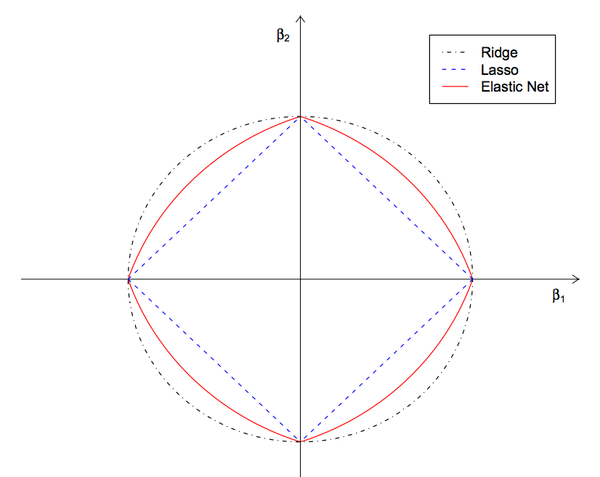

This assignment focuses on creating a coordinate decent Elastic Net model from scratch. Elastic Net is a common methodology for combining lasso (L1) and ridge regression (L2), and it is used as a compromise between both techniques. Importantly, elastic net allows us to control the tradeoff between explicit feature selection and coefficient shrinkage, which makes it a flexible and adaptable regression technique.



---



##Data, Parameter, and Functions Preparation

This section prepares the data from the csv file into numpy arrays and sets up the design and response vectors for vector multiplication in the coordinate decent Elastic Net algorithm. During this process, any categorical features are transformed to a binary (numerical) representation. Next, the design and response vectors are used to create different dataset cohorts for the full dataset and for the 5-fold cross validation training and validation datasets. This section also creates functions to initialize a beta vector with random values from a uniform distribution between [-1,1), and standardize and center the different data cohorts created after splitting into the full dataset and the 5-fold cross validation dataset. Finally, a function is created to pre-compute the Bk vector that is used for the main Elastic Net update. The main Elastic Net function which updates the beta parameters is also included in this section.



In [ ]:
#Dependencies
import pandas as pd
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import numpy as np
import warnings

#Data csv
url = 'https://raw.githubusercontent.com/racs2019/CAP-5625-A2-Data/main/Credit_N400_p9.csv'
df = pd.read_csv(url)

In [ ]:
#Display dataset dataframe
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331


In [ ]:
#Convert cagetory features (gender, student, married) to binary encoding
warnings.filterwarnings('ignore')

for x in range(0,len(df)):
  if df['Gender'][x] == 'Female':
    df['Gender'][x] = 0
  elif df['Gender'][x] == 'Male':
    df['Gender'][x] = 1

for x in range(0,len(df)):
  if df['Student'][x] == 'No':
    df['Student'][x] = 0
  elif df['Student'][x] == 'Yes':
    df['Student'][x] = 1

for x in range(0,len(df)):
  if df['Married'][x] == 'No':
    df['Married'][x] = 0
  elif df['Married'][x] == 'Yes':
    df['Married'][x] = 1

In [ ]:
#Display dataset after converting categorical features
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,1,0,1,333
1,106.025,6645,483,3,82,15,0,1,1,903
2,104.593,7075,514,4,71,11,1,0,0,580
3,148.924,9504,681,3,36,11,0,0,0,964
4,55.882,4897,357,2,68,16,1,0,1,331


In [ ]:
#Response matrix from dataframe
ytemp = df['Balance'].to_numpy()
y = np.ones((400,1))
y[:,0] = ytemp
y = np.array(y, dtype='float')

#Design matrix from dataframe
x = df[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender', 'Student', 'Married']].to_numpy()
x = np.array(x, dtype='float')

In [ ]:
#----------------------------------------------------
#Split dataset into 5-fold cross validation datasets
#----------------------------------------------------

#Full dataset used to train model on all data
x_full = cp.deepcopy(x)
y_full = cp.deepcopy(y)

#Randomly shuffles and splits into 5 batches/folds the reponse and design vectors the same way
shuffler = np.random.permutation(len(x))
Xb = x[shuffler]
Yb = y[shuffler]
x_split = np.split(Xb, 5)
y_split = np.split(Yb, 5)

#x_training_five_fold and y_training_five_fold contain the traning datasets for 5 fold CV
x_training_five_fold = [[], [], [], [], []]
y_training_five_fold = [[], [], [], [], []]

#x_validation_five_fold and y_validation_five_fold contains the validation datasets
x_validation_five_fold = [[], [], [], [], []]
y_validation_five_fold = [[], [], [], [], []]

#Performs the 5-fold cross validation split
for i in range(5):
  temp_x = []
  temp_y = []
  flag = 0
  for j in range(5):
    if j != i:
      if flag == 0:
        temp_x = x_split[j]
        temp_y = y_split[j]
        flag = 1
      elif flag == 1:
        temp_x = np.append(temp_x, x_split[j], axis=0)
        temp_y = np.append(temp_y, y_split[j], axis=0)
    else:
      x_validation_five_fold[i] = x_split[j]
      y_validation_five_fold[i] = y_split[j]
  x_training_five_fold[i] = temp_x
  y_training_five_fold[i] = temp_y

In [ ]:
#------------------------------------------------
#Functions to standardize and center the datasets
#------------------------------------------------

#standardization function for traning dataset
def standardize(data):
  mean_array = np.mean(data, axis=0)
  std_array = np.std(data, axis=0)

  for i in data:
    for j in range(0,9):
      i[j] = (i[j] - mean_array[j])/std_array[j]

#standardization function for validation dataset, uses mean/std from training dataset
def standardize_val(data, validation):
  mean_array = np.mean(data, axis=0)
  std_array = np.std(data, axis=0)

  for i in validation:
    for j in range(0,9):
      i[j] = (i[j] - mean_array[j])/std_array[j]

#Center function for traning dataset
def center(data):
  mean = np.mean(data, axis=0)
  for i in range(0, len(data)):
    data[i] = data[i] - mean

#Center function for validation dataset, uses mean from training dataset
def center_val(data, validation):
  mean = np.mean(data, axis=0)
  for i in range(0, len(validation)):
    validation[i] = validation[i] - mean

In [ ]:
#Perform centering and standardization on traning dataset and validation dataset (using mean and std from training data)
for i in range(0,5):
  standardize_val(x_training_five_fold[i], x_validation_five_fold[i])
  standardize(x_training_five_fold[i])

  center_val(y_training_five_fold[i], y_validation_five_fold[i])
  center(y_training_five_fold[i])

standardize(x_full)
center(y_full)

In [ ]:
#Function to initalize parameter vector beta as random variables from uniform distribution [-1,1)
def init_beta():
  betatemp = np.random.uniform(-1,1,9)
  beta = np.ones((9,1))
  beta[:,0] = betatemp
  return(beta)

In [ ]:
#Function to pre-compute Bk for k = 1,2,3,4...p
def create_Bk(x, y):
  bk_array = [0, 0, 0, 0, 0, 0, 0, 0, 0]
  for k in range(len(x[0])):
    temp = 0
    for i in range(len(x)):
      temp = temp + (x[i][k])**2
    bk_array[k] = temp
  return(bk_array)

In [ ]:
#---------------------------------------------
#Elastic net using coordinate decent function
#---------------------------------------------

#Takes a beta vector, λ and alpha parameter, precomputed bK array, and
#the deisgn and response vectors as input and returns updated beta vector
def elastic_net(beta, lmbda, alpha, x, y, bk_array):
  ak_array = [0, 0, 0, 0, 0, 0, 0, 0, 0]
  for i in range (0,1000):
    for k in range(9):
      test = x[:, k]
      test = test[..., None]
      part_1 = y - np.dot(x, beta)
      part_2 = np.dot(test, beta[k][0])
      part_3 = part_1 + part_2
      ak_array[k] = np.dot(np.transpose(test), part_3)[0][0]
      temp = (abs(ak_array[k]) - lmbda * ((1-alpha)/2))
      if temp < 0:
        temp = 0
      beta[k] = (np.sign(ak_array[k]) * temp) / (bk_array[k] + lmbda * alpha)
  return beta

##Elastic Net on Full Dataset with Varying λ for 6 Different Alpha Values *(Deliverable 1)*

This section trains Elastic Net on the full dataset for each value of λ = [10^-2, 10^-1, 10^0, ..., 10^6] six different times for alpha values 0, 0.2, 0.4, 0.6, 0.8, and 1. For each alpha value, the resulting beta vectors from the respective λ value is then stored in an array and plotted to show how each feature/beta coefficient changes as we increased the λ value. Each individual graph demonstrates how the features tend towards zero as the λ value is increased. Additionally, comparing the graphs with different alpha values, as the alpha value increases from 0 to 1, the model performs more feature 'shrinking' than explicit feature selection as the model has more ridge regression characteristics than lasso regression. As features shrink towards zero at alpha = 0 (full lasso), they stay at zero once they reach it, which shows explicit feature selection. However, at intermediate alpha values and alpha = 1, features no longer get explicitly selected out and cross over the x axis as they shrink towards zero.



In [ ]:
#Function to run elastic net for each value λ = [10^-2, 10^-1, 10^0, ..., 10^6]
#and returns beta values for plotting for a given alpha parameter value
def elastic_net_tuning(x_full, y_full, alpha):
  beta_array = []
  for i in range(0, 9):
    beta = init_beta()
    bk_array = create_Bk(x_full, y_full)
    beta = elastic_net(beta, 10**(i-2), alpha, x_full, y_full, bk_array)
    beta_array.append(beta)

  #Convert the array of all beta values for each λ value into an array of values for a single beta as λ increases
  lmbda_array = [[], [], [], [], [], [], [], [], []]
  for x in beta_array:
    for i in range(0,9):
      lmbda_array[i].append(x[i])
  return lmbda_array

In [ ]:
#Function to plot the effect of λ value on the beta value of each feature/beta parameter
#Requires the final beta value array returned by the elastic_net_tuning function and the alpha value
def plot_differet_lmbda(lmbda_array, a):
  label = ["Income", "Limit", "Rating", "Cards", "Age", "Education", "Gender", "Student", "Married"]
  for i in range(0,9):
    plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], lmbda_array[i], label=label[i])
  plt.title(('Beta Coefficients VS Lambda Parameter at Alpha = ' +  str(a)))
  plt.xlabel("Log10(lambda)")
  plt.ylabel("Beta (B0, B1, B2, B3...B9)")
  leg = plt.legend(loc='best', bbox_to_anchor=(1,1))
  plt.show()

###Alpha = 0

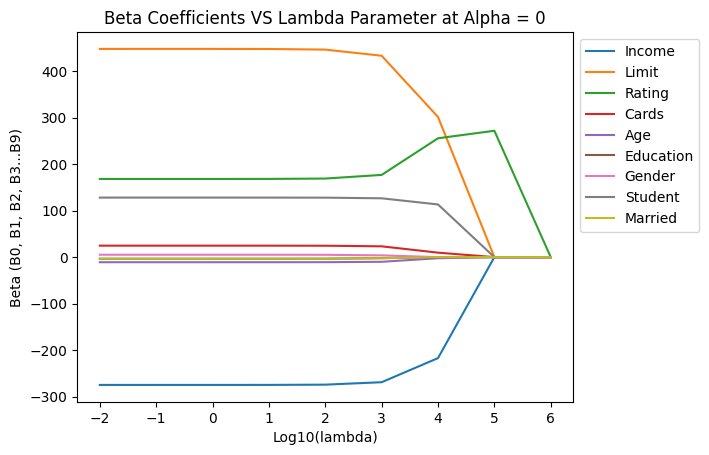

In [ ]:
#------------------------------------------------
#Graph lambda vs beta coefficientys at Alpha = 0
#------------------------------------------------
lmbda_array = elastic_net_tuning(x_full, y_full, 0)
plot_differet_lmbda(lmbda_array, 0)

###Alpha = 0.2

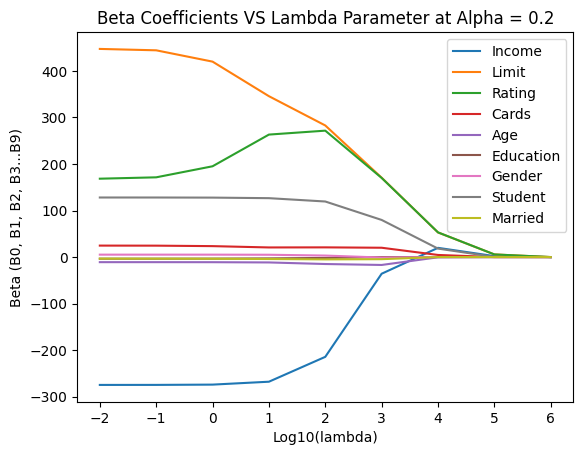

In [ ]:
#-------------------------------------------------
#Graph lambda vs beta coefficientys at Alpha = 0.2
#-------------------------------------------------
lmbda_array = elastic_net_tuning(x_full, y_full, 0.2)
plot_differet_lmbda(lmbda_array, 0.2)

###Alpha = 0.4

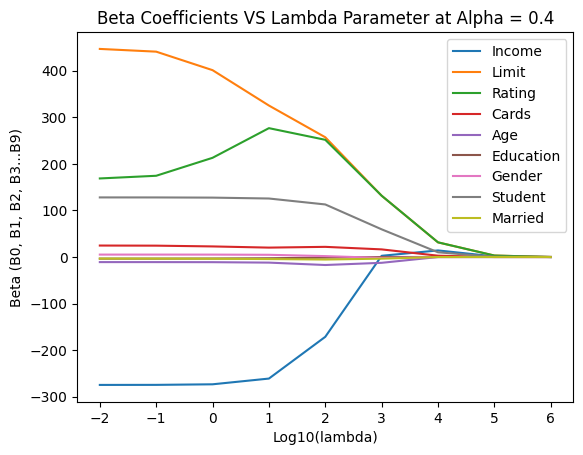

In [ ]:
#-------------------------------------------------
#Graph lambda vs beta coefficientys at Alpha = 0.4
#-------------------------------------------------
lmbda_array = elastic_net_tuning(x_full, y_full, 0.4)
plot_differet_lmbda(lmbda_array, 0.4)

###Alpha = 0.6

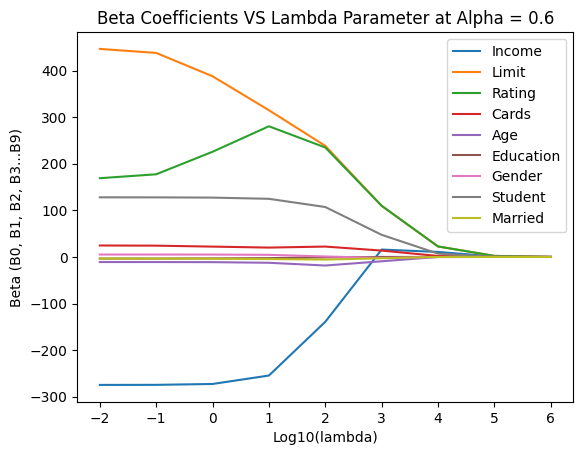

In [ ]:
#-------------------------------------------------
#Graph lambda vs beta coefficientys at Alpha = 0.6
#-------------------------------------------------
lmbda_array = elastic_net_tuning(x_full, y_full, 0.6)
plot_differet_lmbda(lmbda_array, 0.6)

###Alpha = 0.8

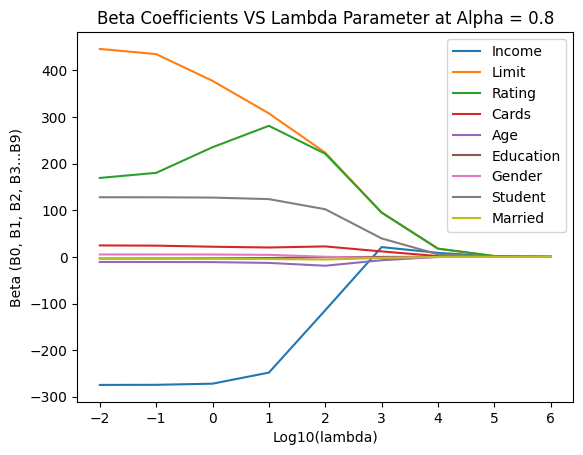

In [ ]:
#-------------------------------------------------
#Graph lambda vs beta coefficientys at Alpha = 0.8
#-------------------------------------------------
lmbda_array = elastic_net_tuning(x_full, y_full, 0.8)
plot_differet_lmbda(lmbda_array, 0.8)

###Alpha = 1

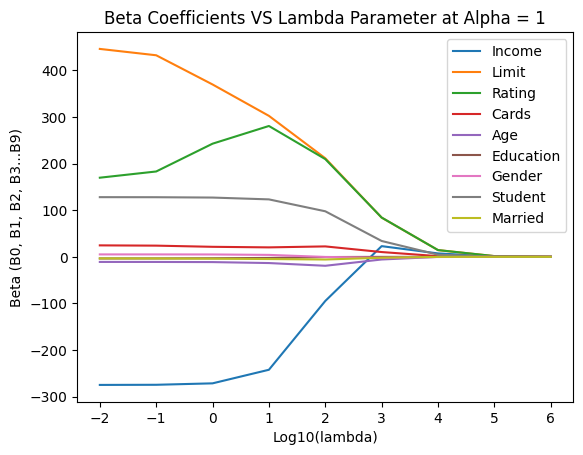

In [ ]:
#-------------------------------------------------
#Graph lambda vs beta coefficientys at Alpha = 1.0
#-------------------------------------------------
lmbda_array = elastic_net_tuning(x_full, y_full, 1)
plot_differet_lmbda(lmbda_array, 1)

##5-Fold Cross Validation and CV Error with Varying λ for Different Alpha Values *(Deliverable 2-3)*

This section trains the 5-fold cross validation dataset on the elastic net model and calculates the 5-fold cross-validation MSE using the validation dataset. The model is run on the cross-validation dataset for each value of λ = [10^-2, 10^-1, 10^0, ..., 10^6], and the MSE is computed for each value of λ. This is repeated 6 times for each value of alpha = 0, 0.2, 0.4, 0.6, 0.8, 1, to produce 6 different MSE arrays as λ increases. Finally, the CV MSE is plotted against the respective λ value for each alpha values to create 6 different lines. The graph shows that significantly increasing the lambda value resulted in worse performance as important coefficients were being forcibly shrunk towards zero. Additionally, it also shows that in general, the model at alpha = 0 where explicit feature selection occurred performed better overall and had a lower MSE as the lambda values increased.




In [ ]:
#Run ridge regression with five fold cross validation for each value λ = [10^-2, 10^-1, 10^0, ..., 10^4]
#and store beta values. Store validation MSE from each varying λ iteration into an array for plotting.
alpha_MSE_array = [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
for i in range(0, 6):
  for j in range(0, 9):
    for k in range(0, 5):
      beta = init_beta()
      bk_array = create_Bk(x_training_five_fold[k], y_training_five_fold[k])
      beta = elastic_net(beta, 10**(j-2), i/5, x_training_five_fold[k], y_training_five_fold[k], bk_array)
      MSE = (np.dot((y_validation_five_fold[k] - np.dot(x_validation_five_fold[k], beta)).transpose(), (y_validation_five_fold[k] - np.dot(x_validation_five_fold[k], beta))))/(len(y_validation_five_fold[k]))
      alpha_MSE_array[i][j] = alpha_MSE_array[i][j] + MSE
    alpha_MSE_array[i][j] = (alpha_MSE_array[i][j]/5)
    alpha_MSE_array[i][j] = alpha_MSE_array[i][j][0][0]

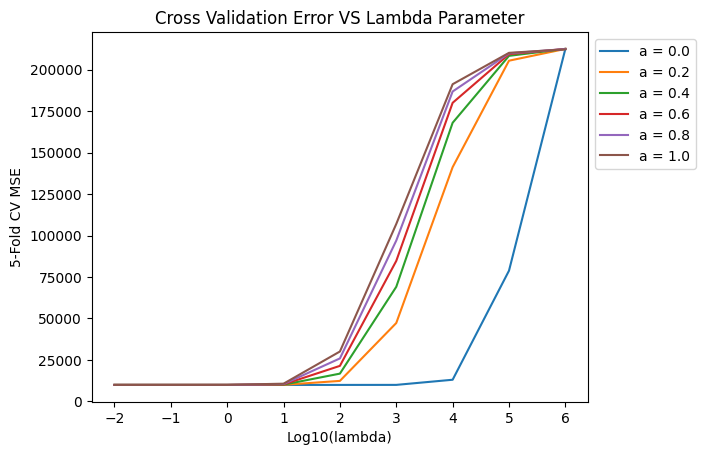

In [ ]:
#Plot the effect of λ value on the cross validation error
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], alpha_MSE_array[0], label='a = 0.0')
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], alpha_MSE_array[1], label='a = 0.2')
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], alpha_MSE_array[2], label='a = 0.4')
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], alpha_MSE_array[3], label='a = 0.6')
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], alpha_MSE_array[4], label='a = 0.8')
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], alpha_MSE_array[5], label='a = 1.0')
leg = plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.title("Cross Validation Error VS Lambda Parameter")
plt.xlabel("Log10(lambda)")
plt.ylabel("5-Fold CV MSE")
plt.show()

In [ ]:
#Compute and display final beta values on full dataset with best λ and alpha
print('Minimum CV error and respective λ and alpha value:\n-----------------------------------')

min_CV = float('inf')
for i in range(len(alpha_MSE_array)):
  min = np.min(alpha_MSE_array[i])
  if min < min_CV:
    min_CV = min
    alpha = i

print('CV error: ', min_CV)
print('a = ', alpha/5)
print('λ = ', 10**(alpha_MSE_array[alpha].index(min_CV)-2))

Minimum CV error and respective λ and alpha value:
-----------------------------------
CV error:  9948.738611256376
a =  0.2
λ =  1


##Elastic Net Using Optimal λ and Alpha on Full Dataset *(Deliverable 4)*

This final section re-trains the elastic net model on the entire dataset using the optimal λ and alpha values found in the previous section when comparing CV MSE. The final beta coefficients are then displayed along with their respective feature labels.



In [ ]:
#Run elastic net on the optimal lambda and alpha values found in the previous section of the full dataset
beta = init_beta()
bk_array = create_Bk(x_full, y_full)
beta = elastic_net(beta, 1, 0.2, x_full, y_full, bk_array)

In [ ]:
#Compute and display final beta values on full dataset with best λ and alpha
print('Final estimates 𝛽̂ = [𝛽̂1, 𝛽̂2, 𝛽̂3, ..., 𝛽̂9] with best λ (λ=1) and a (a=0.6):\n--------------------------------------------------------------------')
print(  '(Income) \t𝛽̂1 = ', beta[0][0], '\n(Limit) \t𝛽̂2 = ', beta[1][0], '\n(Rating) \t𝛽̂3 = ', beta[2][0],
      '\n(Cards) \t𝛽̂4 = ', beta[3][0], '\n(Age) \t\t𝛽̂5 = ', beta[4][0], '\n(Education) \t𝛽̂6 = ', beta[5][0],
      '\n(Gender) \t𝛽̂7 = ', beta[6][0], '\n(Student) \t𝛽̂8 = ', beta[7][0], '\n(Married) \t𝛽̂9 = ', beta[8][0],)

Final estimates 𝛽̂ = [𝛽̂1, 𝛽̂2, 𝛽̂3, ..., 𝛽̂9] with best λ (λ=1) and a (a=0.6):
--------------------------------------------------------------------
(Income) 	𝛽̂1 =  -273.9703420930721 
(Limit) 	𝛽̂2 =  419.8018090014213 
(Rating) 	𝛽̂3 =  195.00815181262513 
(Cards) 	𝛽̂4 =  23.494732173008003 
(Age) 		𝛽̂5 =  -11.012428688066676 
(Education) 	𝛽̂6 =  -3.339161798096311 
(Gender) 	𝛽̂7 =  5.178551295235166 
(Student) 	𝛽̂8 =  127.70564288242757 
(Married) 	𝛽̂9 =  -3.6000780534243937


In [ ]:
#Run lasso regression on the optimal lambda
beta = init_beta()
bk_array = create_Bk(x_full, y_full)
beta = elastic_net(beta, 1, 0, x_full, y_full, bk_array)
print('Coefficient estimates for lasso regression with optimal lambda:')
print('------------------------------------------------------------------')
print(beta)

Coefficient estimates for lasso regression with optimal lambda:
------------------------------------------------------------------
[[-274.6318312 ]
 [ 447.41128824]
 [ 168.02469754]
 [  24.64488504]
 [ -10.93034438]
 [  -3.49106471]
 [   5.19882559]
 [ 127.95340092]
 [  -3.40264319]]


In [ ]:
#Run ridge regression on the optimal lambda
beta = init_beta()
bk_array = create_Bk(x_full, y_full)
beta = elastic_net(beta, 1, 1, x_full, y_full, bk_array)
print('Coefficient estimates for ridge regression with optimal lambda:')
print('------------------------------------------------------------------')
print(beta)

Coefficient estimates for ridge regression with optimal lambda:
------------------------------------------------------------------
[[-271.23140517]
 [ 369.54668115]
 [ 242.58483347]
 [  21.49300028]
 [ -11.27071381]
 [  -3.04537416]
 [   5.09410457]
 [ 127.07840985]
 [  -3.97537715]]


**How do these estimates compare to the estimates obtained from ridge regression (𝛼 = 1
under optimal 𝜆 for 𝛼 = 1) and lasso (𝛼 = 0 under optimal 𝜆 for 𝛼 = 0) on the entire
dataset of 𝑁 = 400 observations?**

The coefficient estimates from the optimal model are very similar to the estimates given by ridge regression (𝛼 = 1) and lasso (𝛼 = 0) under optimal 𝜆. This is supported by the MSE plot comparing the different alpha values, where under the optimal lambda value (first few lambdas are all very similar) the lines are nearly identical. Additionally, the above cells display the coefficient estimates from ridge and lasso regression are shown above, and they are very similar to the coefficients using the optimal lambda and alpha value. There are marginal deviations, but the overall values and coefficient trends are very similar. It is interesting to note that lasso regression is slightly closer to the coefficient values of the optimal model, most notably with the first three features (income, limit, and rating), but this changed with each time I re-ran the model. However, most coefficients were only a few units apart when comparing the three models. Finally, when running the model multiple times on different splits, the optimal lambda and alpha values from the MSE graph were often different due to the very close MSE values for all alpha iterations at smaller lambda values (as shown in the CV MSE graph). Thus, the alpha value is less vital (and the optimal one depends on stochastic factors) at lower values of lambda since shrinking/feature selection is not yet taking place to a great extent.
